<a href="https://colab.research.google.com/github/DiDevv/Vector-Database/blob/main/RAG_with_vectorDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução:

Todo esse código estará armazenado no meu Github com o intuito tanto de guardar o meu aprendizado, quanto de compartilhar para outras pessoas.

Todo aprendizado aquiduirido aqui me foi proporcionado gratuitamente pela organização DeeplearningAI. O curso pode ser encontrado aqui: [Building Applications With Vector Databases](https://learn.deeplearning.ai/courses/building-applications-vector-databases)

A explicação do código estará em português e algumas abordagens alternativas foram tomadas pois estou rodando os códigos em um ambiente meu e não dentro do jupyter do próprio curso.

O curso ainda não possui legendas em português, foi um ponto de dificuldade para mim pois ainda estou aprimorando minha escuta do idioma inglês, por isso, tentarei abordar o conteúdo em português por aqui, para quebrar a barreira linguística para outras pessoas que ainda não conseguem "se virar" no inglês :P, eu te entendo!

Espero que possa ser útil, tanto pra você quanto pra mim!

# Retrieval Augmented Generation (RAG) - Módulo 2

RAG é uma técnica utilizada para recuperação de dados de forma assertiva. É muito útil na área de AI Engineering para otimizar respostas de chatbot que, por exemplo, lidam com documentos.

---

Antes de prosseguir, é necessário instalar alguns pacotes!

In [3]:
%pip install datasets pinecone openai tqdm

# Importando Libs

In [5]:
from datasets import load_dataset
from openai import OpenAI
from pinecone import Pinecone, ServerlessSpec
from tqdm.auto import tqdm

import ast
import os
import pandas as pd
import getpass

# Conectando com o Pinecone e criando um Index

Já detalhei todo esse processo no primeiro módulo, [click aqui](https://github.com/DiDevv/Vector-Database) para acessar o repositório no Github, o módulo um se chama Similarity Search

In [7]:
os.environ["PINECONE_API_KEY"] = getpass.getpass("Forneça sua Pinecone API Key: ")

Forneça sua Pinecone API Key: ··········


In [8]:
PINECONE_API_KEY = os.environ["PINECONE_API_KEY"]

In [9]:
Pinecone = Pinecone(api_key=PINECONE_API_KEY)

index_name = "rag-course"

Pinecone.create_index(
    name=index_name,
    dimension=1536, # é a padrão
    metric="cosine",
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    )
)

In [13]:
index = Pinecone.Index(index_name)

# Baixando o Dataset

Depois que nosso banco de dados foi criado, agora iremos baixar o conjunto de dados que iremos trabalhar.

Utilizarei um conjunto de dados disponibilizado pelo próprio curso.

In [10]:
!wget -q -O lesson2-wiki.csv.zip "https://www.dropbox.com/scl/fi/yxzmsrv2sgl249zcspeqb/lesson2-wiki.csv.zip?rlkey=paehnoxjl3s5x53d1bedt4pmc&dl=0"

!unzip lesson2-wiki.csv.zip

Archive:  lesson2-wiki.csv.zip
  inflating: wiki.csv                


O curso nos deixa uma nota a respeito do conjunto de dados.

---
No curso, eles utilizam um max_articles_num  de 500 para economizar tempo e processamento, mas, obviamente quanto maior o número de dados carregados melhor será a resposta do modelo. Ele sugere que você e eu como alunos possamos aumentar aos poucos o número de artigos para observarmos a melhoria na resposta!

Como sou exagerado, já irei começar com 1000. Sou desses...

In [12]:
max_articles_num = 1000

df = pd.read_csv('./wiki.csv', nrows=max_articles_num)
df.head()

,id,metadata,values
1,1-0,"{'chunk': 0, 'source': 'https://simple.wikiped...","[-0.011254455894231796, -0.01698738895356655, ..."
2,1-1,"{'chunk': 1, 'source': 'https://simple.wikiped...","[-0.0015197008615359664, -0.007858820259571075..."
3,1-2,"{'chunk': 2, 'source': 'https://simple.wikiped...","[-0.009930099360644817, -0.012211072258651257,..."
4,1-3,"{'chunk': 3, 'source': 'https://simple.wikiped...","[-0.011600767262279987, -0.012608098797500134,..."
5,1-4,"{'chunk': 4, 'source': 'https://simple.wikiped...","[-0.026462381705641747, -0.016362832859158516,..."


# "Embeddando" para enviar pro Pinecone

Eu nunca tinha trabalhado com a biblioteca ast antes, então por via das dúvidas, vou dar uma explicada de como ela funciona aqui bem por cima:

O ast.literal_eval consegue converter o dado ao tipo original.
Por exemplo o meu metadata possui chave e valor dentro do meu df, logo, usando o ast.literal_eval eu posso convertê-lo a um dicionário e armazená-lo na minha variável. - Muito interessante, né? - Se eu falei besteira, pls, entra em contato comigo e me corrige, tá? hahaha!

In [14]:
prepped = []

for i, row in tqdm(df.iterrows(), total=df.shape[0]): # o iterrows percorre todo i do dataframe e retorna os dados de cada row
# O total serve pra dizer ao tqdm a quantidade de dados do meu df!
    meta = ast.literal_eval(row['metadata'])
    prepped.append({'id':row['id'],
                    'values':ast.literal_eval(row['values']),
                    'metadata':meta})
    if len(prepped) >= 250: # Aqui estamos processando esses dados em lotes, falamos sobre isso no módulo anterior :P
        index.upsert(prepped)
        prepped = []

  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 1000}},
 'total_vector_count': 1000}

Lá no pinecone a visão é mais ou menos essa!

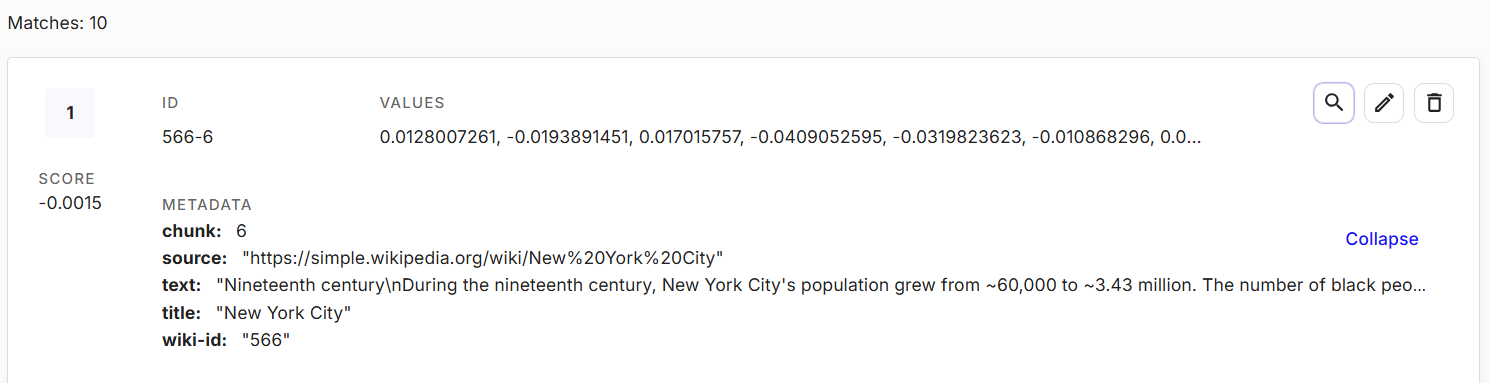

## Conectando a OpenAI

In [16]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("Forneça sua API da OpenAI")

Forneça sua API da OpenAI··········


In [17]:
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

In [19]:
openai_client = OpenAI(api_key=OPENAI_API_KEY)

def get_embeddings(articles, model="text-embedding-ada-002"):
    return openai_client.embeddings.create(input = articles, model=model)

# Exemplo de Query!

In [29]:
query = "Tell me about AI!"

embed = get_embeddings([query])
res = index.query(vector=embed.data[0].embedding, top_k=3, include_metadata=True)
text = [r['metadata']['text'] for r in res['matches']]
print(f'\n'.join(text))

A brilliant mathematician and cryptographer Alan was to become the founder of modern-day computer science and artificial intelligence; designing a machine at Bletchley Park to break secret Enigma encrypted messages used by the Nazi German war machine to protect sensitive commercial, diplomatic and military communications during World War 2. Thus, Turing made the single biggest contribution to the Allied victory in the war against Nazi Germany, possibly saving the lives of an estimated 2 million people, through his effort in shortening World War II.

In 2013, almost 60 years later, Turing received a posthumous Royal Pardon from Queen Elizabeth II. Today, the “Turing law” grants an automatic pardon to men who died before the law came into force, making it possible for living convicted gay men to seek pardons for offences now no longer on the statute book.

Alas, Turing accidentally or otherwise lost his life in 1954, having been subjected by a British court to chemical castration, thus a

# Um mini-bot capaz de interagir com esses dados!

O lado bom dos modelos de LLMs é que eles podem se adaptar ao idioma do usuário. Aqui irei fazer um RAG dos nossos dados que estão originalmente em inglês e irei perguntar tanto em português quanto em inglês. A resposta terá como base o mesmo dado recuperado, mas será traduzida conforme o idioma do prompt ^^!

In [40]:
query="Escreva um texto sobre dança!"

embed = get_embeddings([query])
res = index.query(vector=embed.data[0].embedding, top_k=3, include_metadata=True)

contexts = [
    x['metadata']['text'] for x in res['matches']
]

prompt = f"""Answer the user question baseod on the context below. \n
        Context: {contexts}\n
        User Question: {query}\n
"""

print(prompt)

Answer the user question baseod on the context below. 

        Context: ['Dance is a performing art. It is described in many ways. It is when people move to a musical rhythm. They may be alone, or in a group. The dance may be an informal play, a part of a ritual, or a part of a professional performance. There are many kinds of dances, and every human society has its own dances.\n\nAs with other performing arts, some people dance to express their feelings and emotions, or to feel better. Dance can be used to tell a story. In some societies, dance goes with song as well as music. Dancing is sometimes done as sport, and has similar athletic aspects. People who want to learn to dance can go to dance schools. It may take years of practice to become an experienced and capable dancer.\n\nTo plan a dance is called choreography, done by a choreographer. Often this goes with music, and fits into a certain style. Dances may be planned in detail, or they may be whatever dancers feel like doing. H

In [41]:
res = openai_client.completions.create(
    model="gpt-3.5-turbo-instruct",
    prompt=prompt,
    temperature=0,
    max_tokens=300
)
print('-' * 80)
print(res.choices[0].text)

--------------------------------------------------------------------------------
A dança é uma arte performática que pode ser descrita de várias maneiras. É quando as pessoas se movem ao ritmo da música, podendo estar sozinhas ou em grupo. A dança pode ser uma brincadeira informal, parte de um ritual ou uma performance profissional. Existem muitos tipos de danças e cada sociedade humana tem suas próprias danças.

Assim como outras artes performáticas, algumas pessoas dançam para expressar seus sentimentos e emoções ou para se sentirem melhor. A dança também pode ser usada para contar uma história. Em algumas sociedades, a dança é acompanhada por canções e música. Além disso, a dança também pode ser praticada como esporte, possuindo aspectos atléticos semelhantes. Para aprender a dançar, as pessoas podem frequentar escolas de dança, sendo que pode levar anos de prática para se tornar um dançarino experiente e habilidoso.

O planejamento de uma dança é chamado de coreografia e é feito po

In [43]:
query="Write a text about dance!"

prompt = f"""Answer the user question baseod on the context below. \n
        Context: {contexts}\n
        User Question: {query}\n
"""

res = openai_client.completions.create(
    model="gpt-3.5-turbo-instruct",
    prompt=prompt,
    temperature=0,
    max_tokens=300
)
print('-' * 80)
print(res.choices[0].text)

--------------------------------------------------------------------------------
Dance is a performing art that has been a part of human society for centuries. It is a form of expression that involves moving to a musical rhythm, either alone or in a group. There are many different types of dances, each with its own unique style and purpose. Some people dance to express their emotions, while others use it as a form of storytelling. In some societies, dance is accompanied by song and music. It can also be a form of sport, requiring athleticism and years of practice to become skilled. The planning and creation of a dance is called choreography, and it is often done by a choreographer. There are also professional dancers who have dedicated their lives to perfecting their craft, such as Alvin Ailey, Misty Copeland, and Gene Kelly. In addition to these more formal styles of dance, there are also traditional folk dances that have been passed down for generations. With the rise of popular musi